Total samples: 268114 | positives (paid_back=1): 214068 | negatives: 54046 | pos rate: 0.798
Train size: 214491 | Test size: 53623
Train pos rate: 0.7984204465455427
Using XGBoost scale_pos_weight = 0.252 (neg/pos)
Starting randomized search (this may take a bit).
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best CV AUC: 0.9169620139055633
Best params: {'clf__colsample_bytree': np.float64(0.9140703845572055), 'clf__learning_rate': np.float64(0.05594128078850476), 'clf__max_depth': 6, 'clf__n_estimators': 469, 'clf__subsample': np.float64(0.786705157299192)}

TEST AUC = 0.9210
Saved final pipeline -> finsecure_pipeline.joblib
Saved per-sample predictions to test_predictions.csv


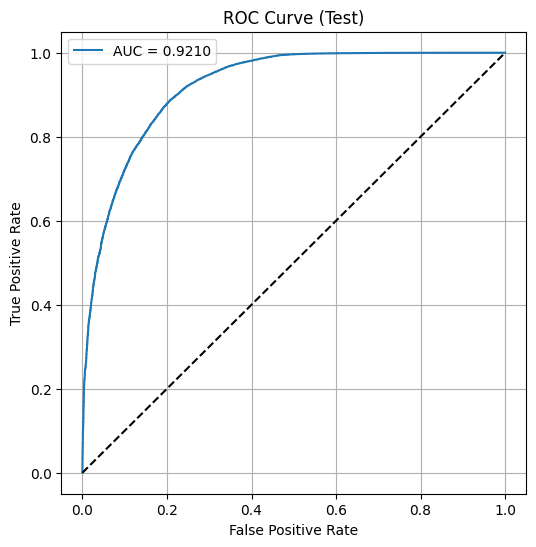


=== AUC by education_level (shows NaN for single-class groups) ===


,education_level,n_samples,auc,flag_small
4,Other,2336,0.932535,False
0,Bachelor's,25263,0.922154,False
1,Master's,8341,0.918972,False
2,High School,16701,0.918261,False
3,PhD,982,0.917442,False



=== AUC by loan_purpose (top 3 / bottom 3) ===

Top 3 loan_purpose by AUC:


,loan_purpose,n_samples,auc,flag_small
1,Education,3202,0.931479,False
4,Medical,2088,0.926361,False
3,Home,4027,0.924973,False



Bottom 3 loan_purpose by AUC:


,loan_purpose,n_samples,auc,flag_small
7,Other,5785,0.921270,False
2,Debt consolidation,29317,0.920235,False
6,Car,5353,0.910389,False



Top feature importances (gain):


,feature,gain
0,annual_income,0.0
1,debt_to_income_ratio,0.0
2,credit_score,0.0
3,loan_amount,0.0
4,interest_rate,0.0
5,loan_purpose_Business,0.0
6,loan_purpose_Car,0.0
7,loan_purpose_Debt consolidation,0.0
8,loan_purpose_Education,0.0
9,loan_purpose_Home,0.0



Done. Files created: finsecure_pipeline.joblib, test_predictions.csv


In [5]:
#   FINSECURE LOAN DEFAULT PREDICTION — IMPROVED SINGLE CELL

!pip install xgboost scikit-learn pandas numpy matplotlib seaborn joblib > /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
MIN_GROUP_SAMPLES = 30

# Load data

df = pd.read_csv("loan_data.csv")
df = df.dropna(subset=["loan_paid_back"])

has_id = 'id' in df.columns
ids = df['id'] if has_id else pd.Series(np.arange(len(df)), index=df.index, name='id')

# Basic target analysis

y_all = df['loan_paid_back'].astype(int)
n_pos = y_all.sum()
n_neg = len(y_all) - n_pos
print(f"Total samples: {len(y_all)} | positives (paid_back=1): {n_pos} | negatives: {n_neg} | pos rate: {n_pos/len(y_all):.3f}")

# Train-test split (stratified)

X = df.drop(columns=['loan_paid_back'], errors='ignore')

# keep id column out of features but keep mapping in 'ids' variable

if 'id' in X.columns:
    X = X.drop(columns=['id'])

y = df['loan_paid_back'].astype(int)

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, ids, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")
print("Train pos rate:", y_train.mean())

# Preprocessing pipeline

numeric_cols = ["annual_income","debt_to_income_ratio","credit_score","loan_amount","interest_rate"]
numeric_cols = [c for c in numeric_cols if c in X.columns]

categorical_nominal = ["loan_purpose","employment_status","gender","marital_status"]
categorical_nominal = [c for c in categorical_nominal if c in X.columns]

ordinal_cols = ["education_level","grade","subgrade"]
ordinal_cols = [c for c in ordinal_cols if c in X.columns]

# Numeric pipeline

num_trans = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_trans = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Ordinal pipeline

ord_trans = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

transformers = []
if numeric_cols:
    transformers.append(("num", num_trans, numeric_cols))
if categorical_nominal:
    transformers.append(("cat", cat_trans, categorical_nominal))
if ordinal_cols:
    transformers.append(("ord", ord_trans, ordinal_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

# Model: set scale_pos_weight to handle imbalance

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print(f"Using XGBoost scale_pos_weight = {scale_pos_weight:.3f} (neg/pos)")

base_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", base_model)
])

# Hyperparameter tuning

param_dist = {
    "clf__n_estimators": randint(150, 500),
    "clf__max_depth": randint(3, 8),
    "clf__learning_rate": uniform(0.02, 0.18),
    "clf__subsample": uniform(0.6, 0.4),
    "clf__colsample_bytree": uniform(0.6, 0.4)
}

# Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=12,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Starting randomized search (this may take a bit).")
search.fit(X_train, y_train)

print("\nBest CV AUC:", search.best_score_)
print("Best params:", search.best_params_)

# Final model & test predictions (aligned indices)

best = search.best_estimator_

# Create predictions aligned with X_test.index

y_proba = pd.Series(best.predict_proba(X_test)[:, 1], index=X_test.index, name='pred_proba')

test_auc = roc_auc_score(y_test.loc[y_proba.index], y_proba)
print(f"\nTEST AUC = {test_auc:.4f}")

# Save pipeline and predictions for reproducibility

joblib.dump(best, "finsecure_pipeline.joblib")
print("Saved final pipeline -> finsecure_pipeline.joblib")

test_out = X_test.copy()
test_out['id'] = id_test.values
test_out['loan_paid_back'] = y_test.values
test_out['pred_proba'] = y_proba.values
test_out.to_csv("test_predictions.csv", index=False)
print("Saved per-sample predictions to test_predictions.csv")

# ROC plot

fpr, tpr, _ = roc_curve(y_test.loc[y_proba.index], y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.grid(True)
plt.show()

# Safe AUC function and subgroup reporting

def safe_auc(y_true, y_score):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_score)

# AUC by education_level (report all, flag small groups)
if 'education_level' in X_test.columns:
    print("\n=== AUC by education_level (shows NaN for single-class groups) ===")
    rows = []
    for level in X_test['education_level'].dropna().unique():
        idx = X_test[X_test['education_level'] == level].index
        n = len(idx)
        auc_val = safe_auc(y_test.loc[idx], y_proba.loc[idx])
        rows.append({'education_level': level, 'n_samples': n, 'auc': auc_val, 'flag_small': n < MIN_GROUP_SAMPLES})
    edu_df = pd.DataFrame(rows).sort_values('auc', ascending=False)
    display(edu_df)
else:
    print("No education_level column present in dataset.")

# AUC by loan_purpose (report top 3 and bottom 3; show counts)
if 'loan_purpose' in X_test.columns:
    print("\n=== AUC by loan_purpose (top 3 / bottom 3) ===")
    rows = []
    for purpose in X_test['loan_purpose'].dropna().unique():
        idx = X_test[X_test['loan_purpose'] == purpose].index
        n = len(idx)
        auc_val = safe_auc(y_test.loc[idx], y_proba.loc[idx])
        rows.append({'loan_purpose': purpose, 'n_samples': n, 'auc': auc_val, 'flag_small': n < MIN_GROUP_SAMPLES})
    lp_df = pd.DataFrame(rows).sort_values('auc', ascending=False)
    print("\nTop 3 loan_purpose by AUC:")
    display(lp_df.head(3))
    print("\nBottom 3 loan_purpose by AUC:")
    display(lp_df.tail(3))
else:
    print("No loan_purpose column present in dataset.")

# --------------------------------
# Feature importance (XGBoost gain) - quick view
# --------------------------------
try:
    clf = best.named_steps['clf']
    # Need to get original feature names after preprocessing
    # Try to reconstruct columns from ColumnTransformer
    pre = best.named_steps['preprocessor']
    # Build feature names
    feature_names = []
    for name, trans, cols in pre.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            # onehot feature names
            ohe = trans.named_steps['onehot']
            # safe: get categories_ if fitted
            if hasattr(ohe, 'get_feature_names_out'):
                out_names = list(ohe.get_feature_names_out(cols))
                feature_names.extend(out_names)
            else:
                feature_names.extend(cols)
        elif name == 'ord':
            feature_names.extend(cols)
    # get importance
    importances = clf.get_booster().get_score(importance_type='gain')
    # Map to full list
    imp_list = [(feature, importances.get(feature, 0.0)) for feature in feature_names]
    imp_df = pd.DataFrame(imp_list, columns=['feature', 'gain']).sort_values('gain', ascending=False).head(15)
    print("\nTop feature importances (gain):")
    display(imp_df)
except Exception as e:
    print("Could not compute feature importances reliably:", e)

print("\nDone. Files created: finsecure_pipeline.joblib, test_predictions.csv")
